In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
from datasets import load_dataset
from collections import Counter
from torchvision import transforms
from tqdm import tqdm
from PIL import Image

/home/punny/anaconda3/envs/tiny_vision/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def setup_data():
    print("--- Starting Data Download/Load ---")
    
    # 1. Download/Load Tiny ImageNet
    dataset = load_dataset("zh-plus/tiny-imagenet")
    
    print("\n--- Dataset Summary ---")
    print(dataset)
    
    # 2. Verify splits
    # Tiny ImageNet contains 100,000 images.
    train_count = len(dataset['train'])
    val_count = len(dataset['valid'])
    print(f"Training images: {train_count}")
    print(f"Validation images: {val_count}")

    # 3. Simple EDA: Visualizing a few samples
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    for i in range(5):
        sample = dataset['train'][i]
        img = sample['image']
        label = sample['label']
        
        # Tiny ImageNet images are 64x64.
        axes[i].imshow(img)
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')
    
    plt.show()
    
    return dataset

--- Starting Data Download/Load ---

--- Dataset Summary ---
DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 100000
    })
    valid: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})
Training images: 100000
Validation images: 10000


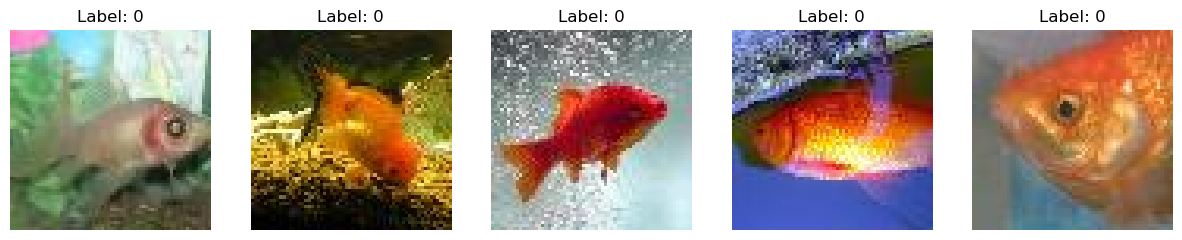

In [3]:
data = setup_data()

## EDA

### Target

In [4]:
def plot_class_distribution(dataset):

    num_classes = 200
    classes = list(range(num_classes))
    train_labels = dataset['train']['label']
    val_labels = dataset['valid']['label']
    train_counts = Counter(train_labels)
    val_counts = Counter(val_labels)
    train_freq = [train_counts[i] for i in classes]
    val_freq = [val_counts[i] for i in classes]

    # 3. Create the Plot
    plt.figure(figsize=(16, 6))
    
    # Plot training data distribution
    plt.bar(classes, train_freq, color='skyblue', label='Train', alpha=0.7)
    # Plot validation data distribution (often much smaller, so we overlay)
    plt.bar(classes, val_freq, color='orange', label='Validation', alpha=0.7)
    
    plt.axhline(y=500, color='r', linestyle='--', label='Target (500/class)')
    
    plt.xlabel('Class Index (0-199)')
    plt.ylabel('Number of Images')
    plt.title('Tiny ImageNet Class Distribution')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig("class_distribution.png") # Saving for documentation
    plt.show()
    

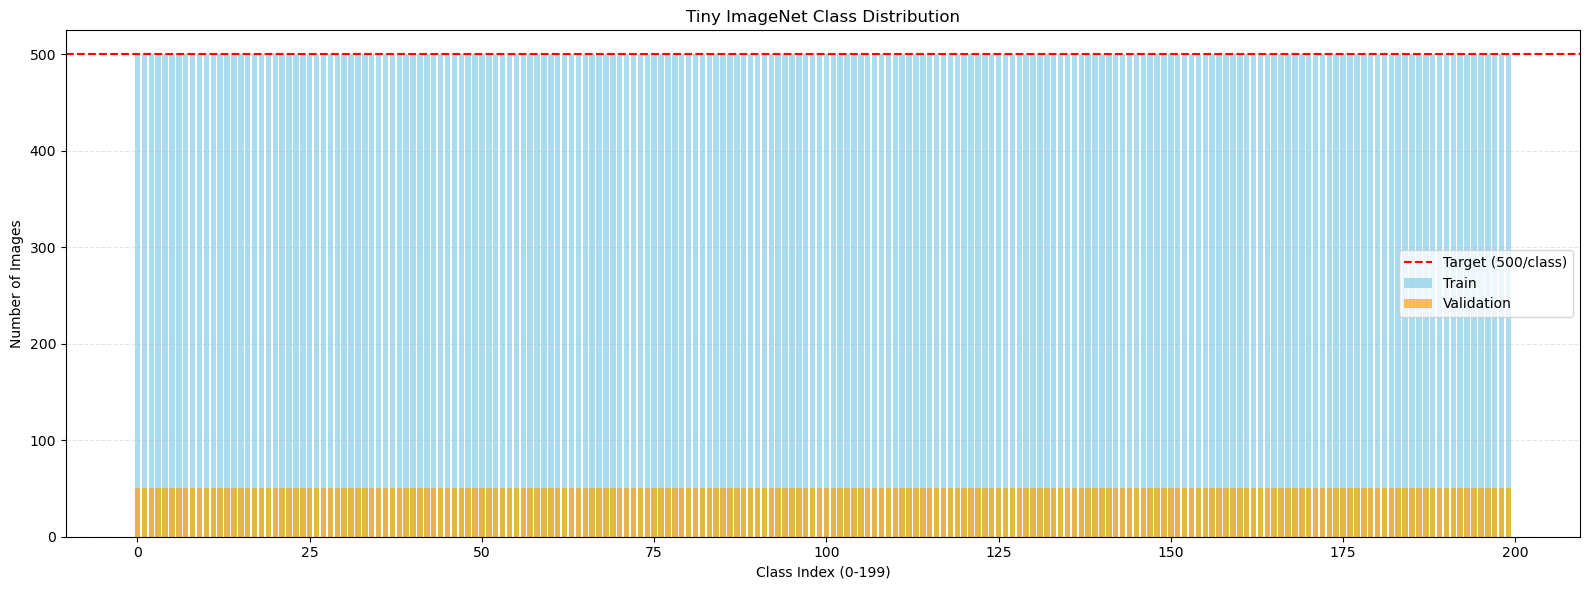

In [5]:
plot_class_distribution(data)

All the classes are perfectly balanced with 500 images per class (200 classes).

This implied that there are risk in "overfitting".

In [6]:
def check_image_specs(dataset):
    print("Analyzing image")
    
    # We'll store tuples of (size, mode) to see the full variety
    specs = []
    
    for item in dataset['train']:
        img = item['image']
        specs.append((img.size, img.mode))
    
    # Use Counter to see how many of each type exist
    spec_counts = Counter(specs)
    
    print("\n--- Image Specification Breakdown ---")
    for spec, count in spec_counts.items():
        size, mode = spec
        format_name = "RGB" if mode == 'RGB' else "Grayscale/Other"
        print(f"Size: {size}, Mode: {mode} ({format_name}) -> Count: {count}")

    return spec_counts

In [7]:
check_image_specs(data)

Analyzing image

--- Image Specification Breakdown ---
Size: (64, 64), Mode: RGB (RGB) -> Count: 98179
Size: (64, 64), Mode: L (Grayscale/Other) -> Count: 1821


Counter({((64, 64), 'RGB'): 98179, ((64, 64), 'L'): 1821})

#### Convert to RGB (For consistantcy and to fit both type of images into one NNs)

In [8]:
def preprocess_and_track(dataset_split):
    """
    Converts images to RGB and tracks which were originally grayscale.
    """
    rgb_images = []
    grayscale_indices = []

    print("Converting images to RGB...")
    for i, example in enumerate(tqdm(dataset_split)):
        img = example['image']
        
        # Track original mode for EDA documentation
        if img.mode != 'RGB':
            grayscale_indices.append(i)
        
        # Standardize to RGB
        rgb_images.append(np.array(img.convert("RGB")))
    
    # Stack into a single 4D array: (N, 64, 64, 3)
    return np.stack(rgb_images), grayscale_indices

def calculate_stats(pixel_array):
    """
    Calculates mean and std across the RGB channels.
    Expects input shape (N, H, W, 3) with values [0, 255].
    """
    # Rescale to [0, 1] for standard ML normalization
    pixel_array = pixel_array.astype(np.float32) / 255.0
    
    # Calculate across all pixels except the channel dimension
    mean = np.mean(pixel_array, axis=(0, 1, 2))
    std = np.std(pixel_array, axis=(0, 1, 2))
    
    return mean, std

In [19]:
def get_precise_stats(processed_images):
    print("Calculating channel statistics...")

    sums = np.zeros(3, dtype=np.float64)
    sq_sums = np.zeros(3, dtype=np.float64)

    num_pixels = len(processed_images) * 64 * 64

    for img in tqdm(processed_images):

        img = img.astype(np.float32) / 255.0
        
        sums += np.sum(img, axis=(0, 1))
        sq_sums += np.sum(np.square(img), axis=(0, 1))

    mean = sums / num_pixels

    std = np.sqrt((sq_sums / num_pixels) - np.square(mean))
    
    return mean, std

In [20]:
processed_images, grayscale_indices = preprocess_and_track(data['train'])
mean_stats, std_stats = get_precise_stats(processed_images)
print(f"\n--- Dataset Pixel Statistics ---")
print(f"Mean (R, G, B): { mean_stats }")
print(f"Std (R, G, B): { std_stats }")

Converting images to RGB...


100%|██████████| 100000/100000 [00:12<00:00, 7867.16it/s]


Calculating channel statistics...


100%|██████████| 100000/100000 [00:12<00:00, 7833.99it/s]


--- Dataset Pixel Statistics ---
Mean (R, G, B): [0.48023712 0.44806758 0.39750453]
Std (R, G, B): [0.27643518 0.26886158 0.28158808]
